<Figure size 1200x800 with 0 Axes>

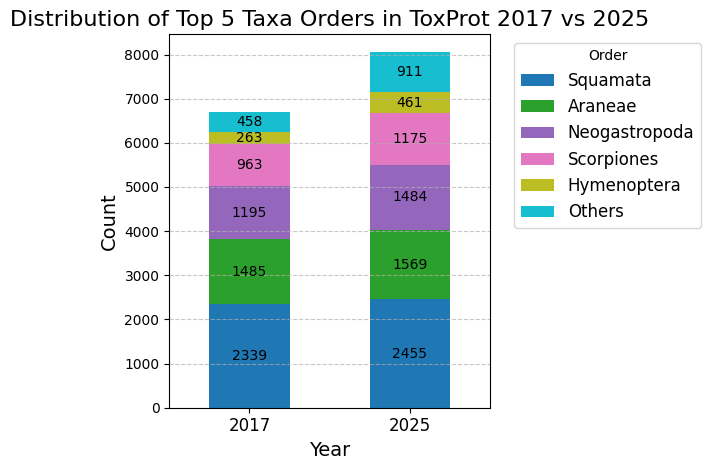

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
toxprot_2017 = pd.read_csv("../data/processed/toxprot_2017.csv")
toxprot_2025 = pd.read_csv("../data/processed/toxprot_2025.csv")


# Function to get top N taxa and group the rest as "Others"
def get_top_taxa_counts(df, taxa_column="Order", top_n=5):
    taxa_counts = df[taxa_column].value_counts()
    top_taxa = taxa_counts.nlargest(top_n)

    # Create a dictionary with all taxa counts
    result = top_taxa.to_dict()

    # Add "Others" category
    others_count = taxa_counts[~taxa_counts.index.isin(top_taxa.index)].sum()
    result["Others"] = others_count

    return result


# Get top 5 taxa for each dataset
top_taxa_2017 = get_top_taxa_counts(toxprot_2017, "Order", 5)
top_taxa_2025 = get_top_taxa_counts(toxprot_2025, "Order", 5)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({"2017": top_taxa_2017, "2025": top_taxa_2025})

# Fill NaN with 0 (in case some taxa are in one year but not the other)
plot_data = plot_data.fillna(0)

# Transpose the DataFrame to have years on x-axis and taxa as stacked components
plot_data = plot_data.T

# Set up the plot
plt.figure(figsize=(12, 8))
ax = plot_data.plot(kind="bar", stacked=True, colormap="tab10")

# Customize the plot
plt.title("Distribution of Top 5 Taxa Orders in ToxProt 2017 vs 2025", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Order", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type="center", fmt="%d")

# Add a grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()

# Save the plot
plt.savefig("../figures/taxa/top_taxa_distribution.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


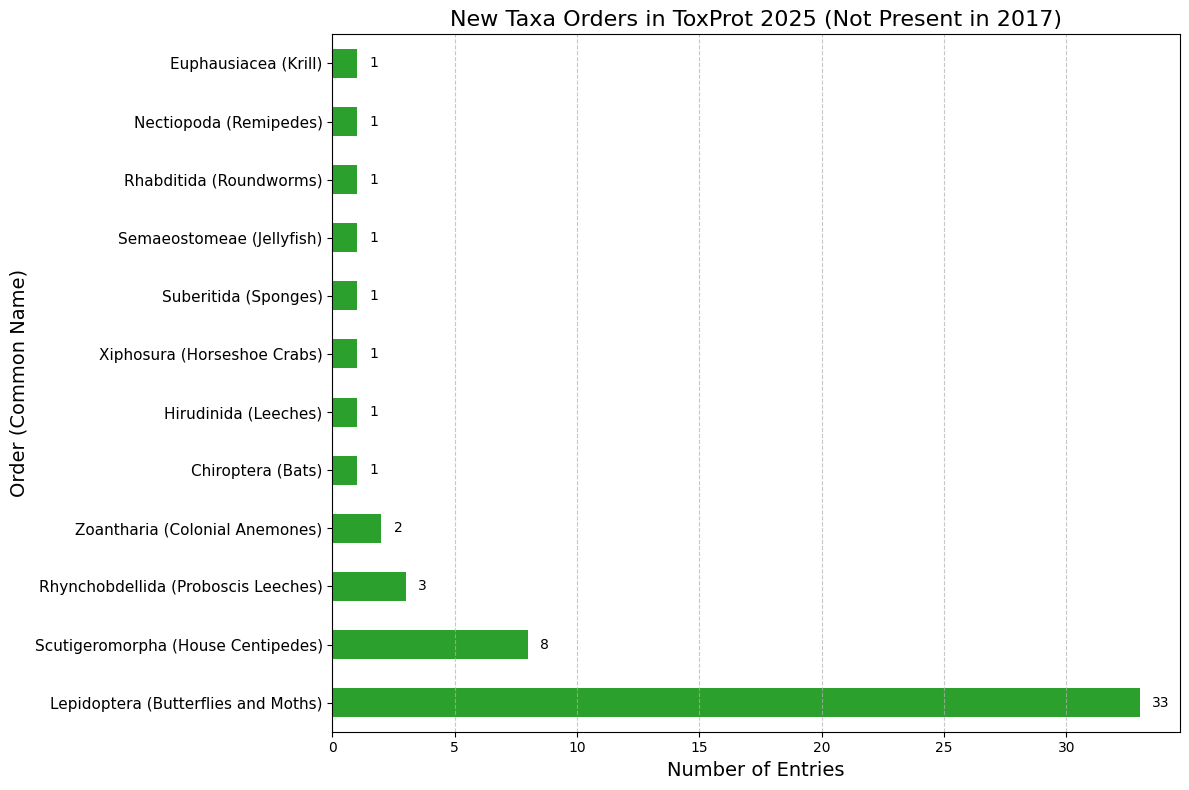

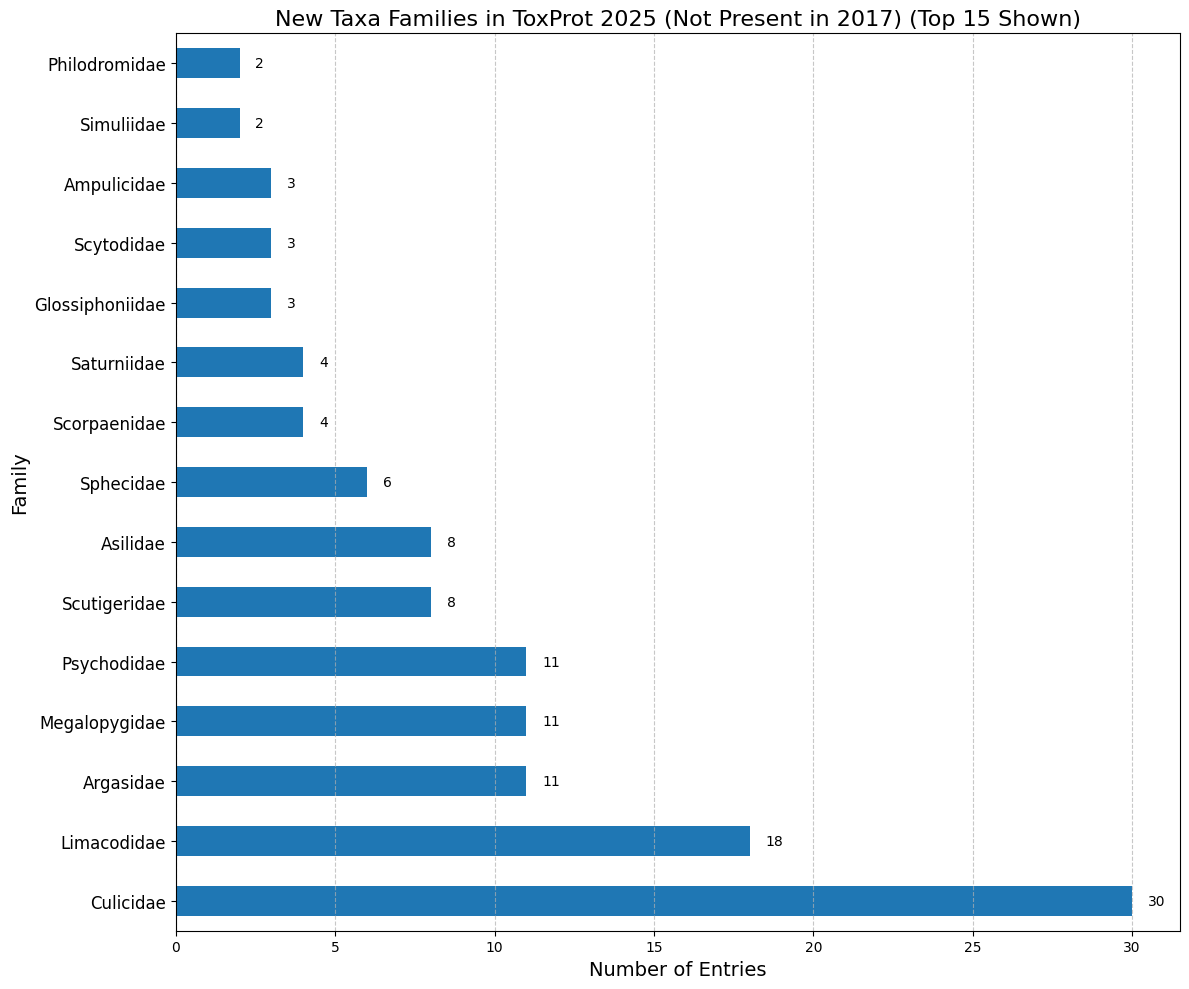

In [3]:
# Find taxa newcomers (present in 2025 but not in 2017)
def get_taxa_newcomers(df_2017, df_2025, taxa_level="Order"):
    """Identify taxa present in 2025 dataset but not in 2017 dataset."""
    # Get unique taxa in each dataset and find newcomers
    taxa_2017 = set(df_2017[taxa_level].unique())
    taxa_2025 = set(df_2025[taxa_level].unique())
    newcomers = taxa_2025 - taxa_2017

    # Count occurrences of newcomers in 2025 dataset
    return df_2025[df_2025[taxa_level].isin(newcomers)][taxa_level].value_counts()


# Dictionary mapping orders to common names
order_common_names = {
    "Lepidoptera": "Butterflies and Moths",
    "Scutigeromorpha": "House Centipedes",
    "Rhynchobdellida": "Proboscis Leeches",
    "Zoantharia": "Colonial Anemones",
    "Chiroptera": "Bats",
    "Hirudinida": "Leeches",
    "Xiphosura": "Horseshoe Crabs",
    "Suberitida": "Sponges",
    "Semaeostomeae": "Jellyfish",
    "Rhabditida": "Roundworms",
    "Nectiopoda": "Remipedes",
    "Euphausiacea": "Krill",
}

# Get newcomers at Order level
order_newcomers = get_taxa_newcomers(toxprot_2017, toxprot_2025, "Order")

# Plot newcomers at Order level
plt.figure(figsize=(12, 8))
plot_data = order_newcomers.head(15) if len(order_newcomers) > 15 else order_newcomers
title_suffix = " (Top 15 Shown)" if len(order_newcomers) > 15 else ""

# Create horizontal bar chart with enhanced labels
ax = plot_data.plot(kind="barh", color="tab:green")

# Add common names to the y-axis labels
labels = [
    f"{order} ({order_common_names.get(order, 'Unknown')})" for order in plot_data.index
]
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=11)

# Customize the plot
plt.title(
    f"New Taxa Orders in ToxProt 2025 (Not Present in 2017){title_suffix}", fontsize=16
)
plt.xlabel("Number of Entries", fontsize=14)
plt.ylabel("Order (Common Name)", fontsize=14)

# Add value labels
for i, v in enumerate(plot_data):
    ax.text(v + 0.5, i, str(v), va="center", fontsize=10)

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig("../figures/taxa/taxa_newcomers_order.png", dpi=300, bbox_inches="tight")

plt.show()

# Also analyze at Family level
family_newcomers = get_taxa_newcomers(toxprot_2017, toxprot_2025, "Family")

# Plot top newcomer families
plt.figure(figsize=(12, 10))
plot_data = (
    family_newcomers.head(15) if len(family_newcomers) > 15 else family_newcomers
)
title_suffix = " (Top 15 Shown)" if len(family_newcomers) > 15 else ""

ax = plot_data.plot(kind="barh", color="tab:blue")
plt.title(
    f"New Taxa Families in ToxProt 2025 (Not Present in 2017){title_suffix}",
    fontsize=16,
)
plt.xlabel("Number of Entries", fontsize=14)
plt.ylabel("Family", fontsize=14)
plt.yticks(fontsize=12)

# Add value labels
for i, v in enumerate(plot_data):
    ax.text(v + 0.5, i, str(v), va="center", fontsize=10)

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig("../figures/taxa/taxa_newcomers_family.png", dpi=300, bbox_inches="tight")

plt.show()


<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

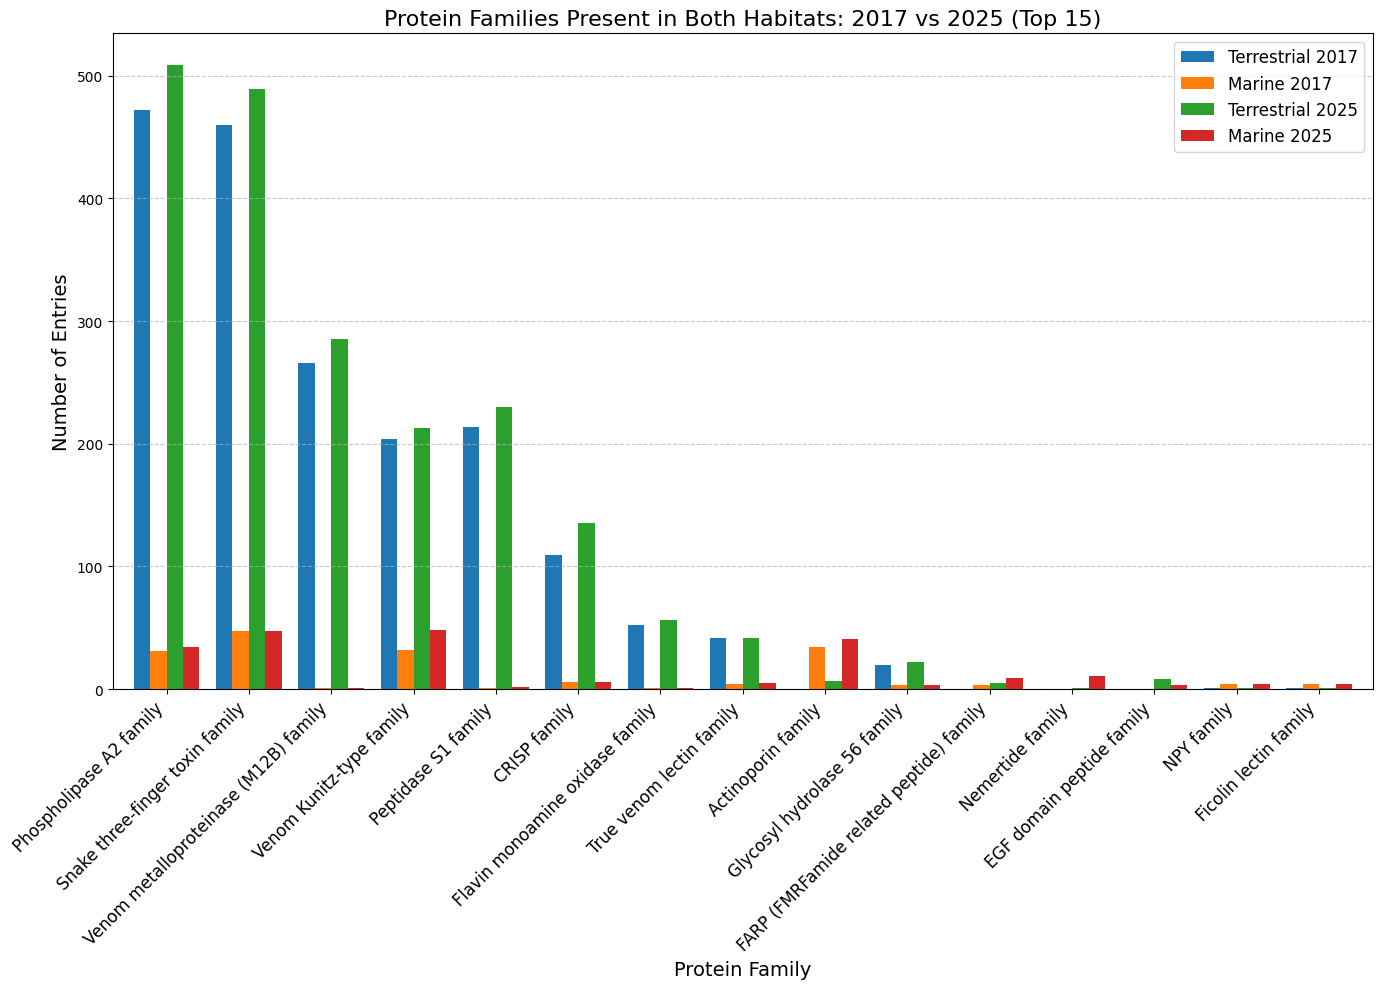

<Figure size 1400x1000 with 0 Axes>

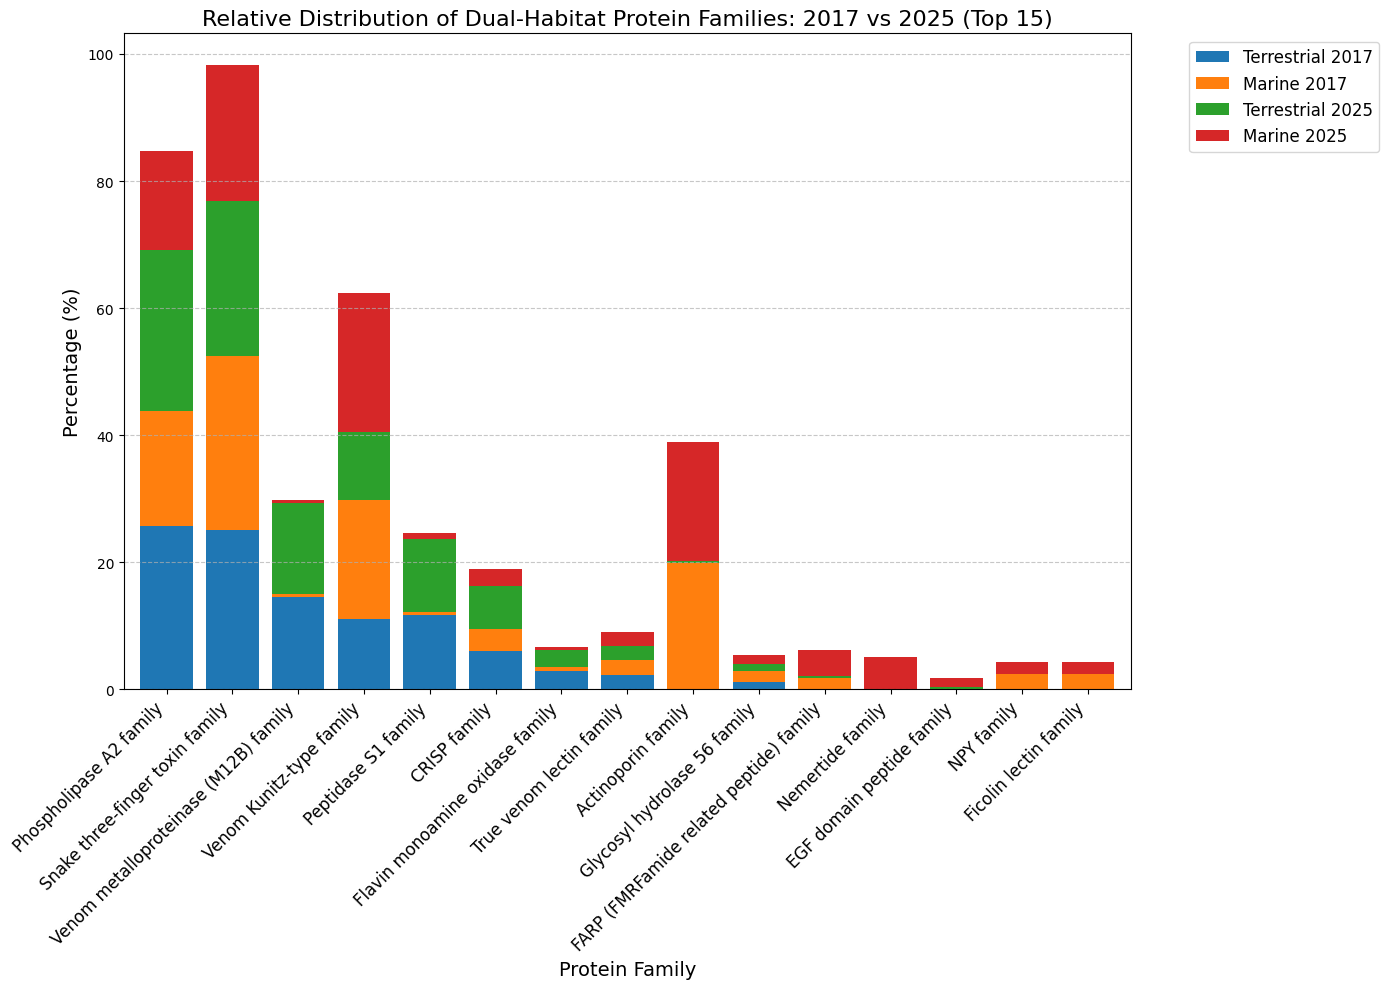

In [36]:
# Create a terrestrial vs marine protein family comparison plot (2017 vs 2025)
plt.figure(figsize=(14, 10))


def get_protein_family_by_habitat(df, habitat_type, split_char):
    """Extract protein family counts for a specific habitat type"""
    habitat_data = df[df["Habitat"] == habitat_type].copy()
    habitat_data["Protein families"] = (
        habitat_data["Protein families"].str.split(split_char).str[0]
    )
    return habitat_data["Protein families"].value_counts().sort_index()


# Get data for both years and habitats
terrestrial_2017 = get_protein_family_by_habitat(toxprot_2017, "terrestrial", ".")
marine_2017 = get_protein_family_by_habitat(toxprot_2017, "marine", ".")
terrestrial_2025 = get_protein_family_by_habitat(toxprot_2025, "terrestrial", ",")
marine_2025 = get_protein_family_by_habitat(toxprot_2025, "marine", ",")

# Find protein families present in both habitats across both years
both_habitats = (set(terrestrial_2017.index) & set(marine_2017.index)) | (
    set(terrestrial_2025.index) & set(marine_2025.index)
)

# Create dataframe with protein families present in both habitats
dual_habitat_data = {
    "Terrestrial 2017": terrestrial_2017.loc[
        terrestrial_2017.index.isin(both_habitats)
    ],
    "Marine 2017": marine_2017.loc[marine_2017.index.isin(both_habitats)],
    "Terrestrial 2025": terrestrial_2025.loc[
        terrestrial_2025.index.isin(both_habitats)
    ],
    "Marine 2025": marine_2025.loc[marine_2025.index.isin(both_habitats)],
}

# Prepare data for visualization
dual_habitat_df = pd.DataFrame(dual_habitat_data).fillna(0)
dual_habitat_df = (
    dual_habitat_df.assign(Total=dual_habitat_df.sum(axis=1))
    .sort_values("Total", ascending=False)
    .drop("Total", axis=1)
)

# Get top 15 for visualization
top_n = 15
top_dual_habitat = dual_habitat_df.head(top_n)

# Create grouped bar chart
plt.figure(figsize=(14, 10))
ax = top_dual_habitat.plot(kind="bar", figsize=(14, 10), width=0.8)
plt.title(
    f"Protein Families Present in Both Habitats: 2017 vs 2025 (Top {top_n})",
    fontsize=16,
)
plt.xlabel("Protein Family", fontsize=14)
plt.ylabel("Number of Entries", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig(
    "../figures/taxa/habitat_protein_families_grouped.png", dpi=300, bbox_inches="tight"
)

plt.show()

# Create percentage stacked bar chart
plt.figure(figsize=(14, 10))
percentage_dual = top_dual_habitat.copy()
for col in percentage_dual.columns:
    percentage_dual[col] = percentage_dual[col] / percentage_dual[col].sum() * 100

percentage_dual.plot(kind="bar", stacked=True, figsize=(14, 10), width=0.8)
plt.title(
    f"Relative Distribution of Dual-Habitat Protein Families: 2017 vs 2025 (Top {top_n})",
    fontsize=16,
)
plt.xlabel("Protein Family", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig(
    "../figures/taxa/habitat_protein_families_percentage.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()
